GPU 할당 체크

In [ ]:
!nvidia-smi -L

GPU 0: Tesla T4 (UUID: GPU-c628ab98-4025-867a-f9d9-32b1860d9a89)


드라이브 마운트 (굳이 안해도 될 것 같긴 한데, 일단 넣어뒀음

In [ ]:
from google.colab import drive
drive.mount('/content/drive/MyDrive/Colab Notebook/Training/CafeterraceAtNight')

In [2]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision.utils as utils
import torchvision.datasets as dsets
import torchvision.transforms as transforms

is_cuda = torch.cuda.is_available()
device = torch.device('cuda' if is_cuda else 'cpu')

In [3]:
# standardization code
standardizator = transforms.Compose([
                    transforms.ToTensor(),
                   transforms.Normalize((0.5,), (0.5,))])

# MNIST dataset
data_path = '/content/drive/MyDrive/Colab Notebooks/Training/CafeterraceAtNight/data'
train_data = dsets.MNIST(root= data_path, train=True, transform=standardizator, download=True)
test_data  = dsets.MNIST(root= data_path, train=False, transform=standardizator, download=True)


batch_size = 200
train_data_loader = torch.utils.data.DataLoader(train_data, batch_size, shuffle=True)
test_data_loader  = torch.utils.data.DataLoader(test_data, batch_size, shuffle=True)

/usr/local/lib/python3.7/dist-packages/torchvision/datasets/mnist.py:498: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at  /pytorch/torch/csrc/utils/tensor_numpy.cpp:180.)
  return torch.from_numpy(parsed.astype(m[2], copy=False)).view(*s)


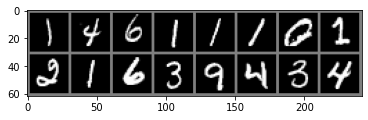

tensor([1, 4, 6, 1, 1, 1, 0, 1, 2, 1, 6, 3, 9, 4, 3, 4])


In [4]:
import numpy as np
from matplotlib import pyplot as plt

def imshow(img):
    img = (img+1)/2    
    img = img.squeeze()
    np_img = img.numpy()
    plt.imshow(np_img, cmap='gray')
    plt.show()

def imshow_grid(img): 
    img = utils.make_grid(img.cpu().detach())
    img = (img+1)/2
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1,2,0)))
    plt.show()
    
example_mini_batch_img, example_mini_batch_label  = next(iter(train_data_loader))
imshow_grid(example_mini_batch_img[0:16,:,:])
print(example_mini_batch_label[0:16])

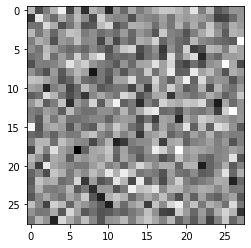

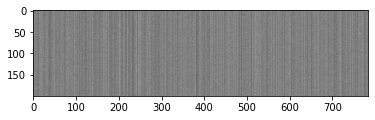

In [ ]:
d_noise  = 100
d_hidden = 256

def sample_z(batch_size = 1, d_noise=100):
    return torch.randn(batch_size, d_noise, device=device)

G = nn.Sequential(
    nn.Linear(d_noise, d_hidden),
    nn.ReLU(),
    nn.Dropout(0.1),
    nn.Linear(d_hidden,d_hidden),
    nn.ReLU(),
    nn.Dropout(0.1),
    nn.Linear(d_hidden, 28*28),
    nn.Tanh()
).to(device)

# 노이즈 생성하기
z = sample_z()
# 가짜 이미지 생성하기
img_fake = G(z).view(-1,28,28)
# 이미지 출력하기
imshow(img_fake.squeeze().cpu().detach())

# Batch SIze만큼 노이즈 생성하여 그리드로 출력하기
z = sample_z(batch_size)
img_fake = G(z)
imshow_grid(img_fake)

In [ ]:
D = nn.Sequential(
    nn.Linear(28*28, d_hidden),
    nn.LeakyReLU(),
    nn.Dropout(0.1),
    nn.Linear(d_hidden, d_hidden),
    nn.LeakyReLU(),
    nn.Dropout(0.1),
    nn.Linear(d_hidden, 1),
    nn.Sigmoid()
).to(device)

print(G(z).shape)
print(D(G(z)).shape)
print(D(G(z)[0:5]).transpose(0,1))

torch.Size([200, 784])
torch.Size([200, 1])
tensor([[0.5148, 0.5152, 0.5157, 0.5142, 0.5151]], device='cuda:0',
       grad_fn=<TransposeBackward0>)


In [ ]:
criterion = nn.BCELoss()

def run_epoch(generator, discriminator, _optimizer_g, _optimizer_d):
    
    generator.train()
    discriminator.train()

    for img_batch, label_batch in train_data_loader:
        
        img_batch, label_batch = img_batch.to(device), label_batch.to(device) 

        # ================================================  #
        # maximize V(discriminator,generator) = optimize discriminator (setting k to be 1)  #
        # ================================================  #

        # init optimizer
        _optimizer_d.zero_grad()

        p_real = discriminator(img_batch.view(-1, 28*28))
        p_fake = discriminator(generator(sample_z(batch_size, d_noise)))

        # ================================================  #
        #    Loss computation (soley based on the paper)    #
        # ================================================  #
        loss_real = -1 * torch.log(p_real)   # -1 for gradient ascending
        loss_fake = -1 * torch.log(1.-p_fake) # -1 for gradient ascending
        loss_d    = (loss_real + loss_fake).mean()
        
        # ================================================  #
        #     Loss computation (based on Cross Entropy)     #
        # ================================================  #
        # loss_d = criterion(p_real, torch.ones_like(p_real).to(device)) + \    #
        #          criterion(p_fake, torch.zeros_like(p_real).to(device))       #
        
        # Update parameters
        loss_d.backward()
        _optimizer_d.step()

        # ================================================  #
        #        minimize V(discriminator,generator)        #
        # ================================================  #

        # init optimizer
        _optimizer_g.zero_grad()

        p_fake = discriminator(generator(sample_z(batch_size, d_noise)))
                
        # ================================================  #
        #    Loss computation (soley based on the paper)    #
        # ================================================  #
        
        # instead of: torch.log(1.-p_fake).mean() <- explained in Section 3
        loss_g = -1 * torch.log(p_fake).mean() 

        # ================================================  #
        #     Loss computation (based on Cross Entropy)     #
        # ================================================  #
        # loss_g = criterion(p_fake, torch.ones_like(p_fake).to(device)) #

        loss_g.backward()
   
        # Update parameters
        _optimizer_g.step()
          
def evaluate_model(generator, discriminator):
    
    p_real, p_fake = 0.,0.
    
    generator.eval()
    discriminator.eval()
        
    for img_batch, label_batch in test_data_loader:
        
        img_batch, label_batch = img_batch.to(device), label_batch.to(device) 
        
        with torch.autograd.no_grad():
            p_real += (torch.sum(discriminator(img_batch.view(-1, 28*28))).item())/10000.
            p_fake += (torch.sum(discriminator(generator(sample_z(batch_size, d_noise)))).item())/10000.
            
            
    return p_real, p_fake

(epoch 50/200) p_real: 0.764545, p_g: 0.213394


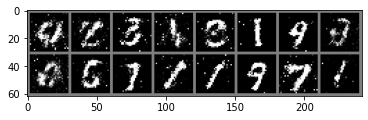

(epoch 100/200) p_real: 0.630501, p_g: 0.309332


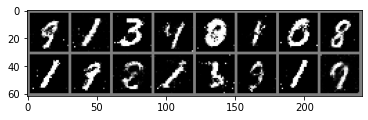

(epoch 150/200) p_real: 0.632777, p_g: 0.307025


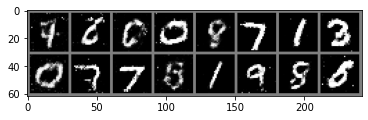

(epoch 200/200) p_real: 0.587717, p_g: 0.334504


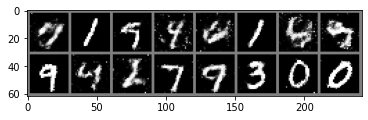

In [ ]:
def init_params(model):
    for p in model.parameters():
        if(p.dim() > 1):
            nn.init.xavier_normal_(p)
        else:
            nn.init.uniform_(p, 0.1, 0.2)

init_params(G)
init_params(D)

optimizer_g = optim.Adam(G.parameters(), lr = 0.0002)
optimizer_d = optim.Adam(D.parameters(), lr = 0.0002)

p_real_trace = []
p_fake_trace = []

for epoch in range(200):
    
    run_epoch(G, D, optimizer_g, optimizer_d)
    p_real, p_fake = evaluate_model(G,D)
    
    p_real_trace.append(p_real)
    p_fake_trace.append(p_fake) 
    
    if((epoch+1)% 50 == 0):
        print('(epoch %i/200) p_real: %f, p_g: %f' % (epoch+1, p_real, p_fake))
        imshow_grid(G(sample_z(16)).view(-1, 1, 28, 28))

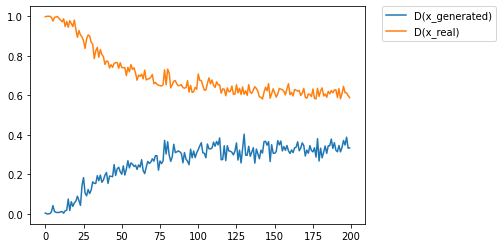

In [ ]:
plt.plot(p_fake_trace, label='D(x_generated)')
plt.plot(p_real_trace, label='D(x_real)')
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)

plt.show()

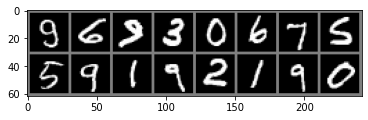

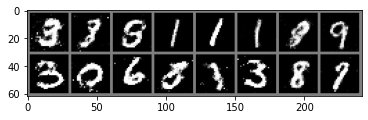

In [ ]:
vis_loader = torch.utils.data.DataLoader(test_data, 16, True)
img_vis, label_vis   = next(iter(vis_loader))
imshow_grid(img_vis)

imshow_grid(G(sample_z(16,100)).view(-1, 1, 28, 28))